<center> <h1>Homework 3</h1> </center>
<p style="text-align: center;">author: EL FATTAHI Charaf-Ed-Dine</p>

This homework solution has been inspired from [IFT 6390](https://admission.umontreal.ca/cours-et-horaires/cours/ift-6390/) homeworks as well as the work of [Francois David](https://www.zspapapa.com/francoisdavid).

**IMPORTANT**

* To run this code, make sure you adjust the path to the .csv file in the 15th line of the second cell according to you!

# Imports

In [74]:
import numpy as np 
import pandas as pd
import time
import timeit
import os
import scipy

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Logistic Regression and Retrospective Approximation

In [88]:
class LogisticRegression(object):
    def __init__(self,
                 optimizer='gd',
                 gd_lr=0.001,
                 eps=1e-8):
        # Save the optimizer
        self.optimizer = optimizer

        # Save hyperparameter settings
        self.gd_lr = gd_lr  # gd learning rate
        self.eps = eps  # epsilon, for numerical stability

        # Load the data
        # self.df = pd.read_csv(os.path.join(data_path, 'bank/bank-full.csv'), sep=";")
        self.df = pd.read_csv('data/bank/bank-full.csv', sep=";")

        # Encoding data
        cols = self.df.columns
        num_cols = self.df._get_numeric_data().columns
        cat_cols = list(set(cols) - set(num_cols))

        ordinal_encoder = OrdinalEncoder()
        self.df[cat_cols] = ordinal_encoder.fit_transform(self.df[cat_cols])

        # split data into train, test and valid
        self.train_data, self.test_data = train_test_split(self.df, test_size=0.2, random_state=1)
        self.train_data, self.val_data = train_test_split(self.train_data, test_size=0.25, random_state=1)

        # labels
        self.train_labels = self.train_data.y
        self.test_labels = self.test_data.y
        self.val_labels = self.val_data.y

        # drop the target value
        self.train_data = self.train_data.drop(['y'], axis=1)
        self.test_data = self.test_data.drop(['y'], axis=1)
        self.val_data = self.val_data.drop(['y'], axis=1)

        # transform back to numpy array
        self.train_data = self.train_data.to_numpy()
        self.test_data = self.test_data.to_numpy()
        self.val_data = self.val_data.to_numpy()
        self.train_labels = self.train_labels.to_numpy()
        self.test_labels = self.test_labels.to_numpy()
        self.val_labels = self.val_labels.to_numpy()

        # Prepend a vector of all ones to each of the dataset
        self.train_data = np.hstack([np.ones_like(self.train_data[:, 0])[:, np.newaxis], self.train_data])
        self.val_data = np.hstack([np.ones_like(self.val_data[:, 0])[:, np.newaxis], self.val_data])
        self.test_data = np.hstack([np.ones_like(self.test_data[:, 0])[:, np.newaxis], self.test_data])

        # Initialize the weight matrix
        np.random.seed(seed=42)
        self.start_w = np.random.rand(self.train_data.shape[1])

        # Initialize the train logs
        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': []}

    def sigmoid(self, a: np.float128):
        """
        inputs:
            v: float

        returns:
            the logistic sigmoid evaluated at a
        """
        # we use the scipy sigmoid instead of np.exp() to avoid RuntimeWarning: overflow
        return scipy.special.expit(a)
        # return 1 / (1 + np.exp(-a))

    def forward(self, w, X):
        """
        inputs: w: an array of the current weights, of shape (d,)
                X: an array of n datapoints, of shape (n, d)

        outputs: an array of the output of the logistic regression (not 0s and 1s yet)
        """
        return self.sigmoid(np.dot(X, w))

    def loss(self, w, X, y):
        """
        inputs: w: an array of the current weights, of shape (d,)
                X: an array of n datapoints, of shape (n, d)

        outputs: the loss. This is exactly the negative log likelihood
        """
        E = 10 ** (-8)
        y_pred = self.sigmoid(np.dot(X, w))
        cost = -np.sum(y * np.log(y_pred + E) + (1 - y) * np.log(1 - y_pred + E))
        return cost

    def gradient(self, w, X, y):
        """
        inputs:
            w: an array of the current weights

        returns:
            an array representing the gradient of the loss
        """
        grad = np.dot(X.T, (self.sigmoid(np.dot(X, w)) - y))
        return grad

    def gd_step(self, grad, w, alpha):
        """
        inputs:
            w: an array of the current weights

        returns:
            a vector of weights updated according to a step of gradient descent
            on the whole train dataset, using the learning rate self.gd_lr
        """
        wnext = w - alpha * grad
        return wnext

    def compute_average_loss_and_accuracy(self, w, X, y):
        outputs = self.forward(w, X)
        predictions = np.array(np.round(outputs), dtype=int)
        accuracy = np.mean(y == predictions)
        loss = self.loss(w, X, y) / X.shape[0]
        return loss, accuracy, predictions

    def predict(self, X, w):
        y_predict = self.forward(X, w)
        return y_predict

    def train_loopRetroApprox(self, iterations):
        X = self.train_data
        y = self.train_labels
        
        # starting weights
        w = np.copy(self.start_w)
        batch_size = 1
        alpha = 0.9999

        # starting sample size 
        sampleSize = 100 
        iteration =  0
        ErrorThreshold = 0.8
        ErrorPercent = 1.0
        wX =  {} 
        previousLoss = 2147483647

        cumulIdx = 0
        gradsOld = {}
        ep = np.arange(iterations)
        for iteration in range(iterations):
            start = timeit.default_timer()
            # Error reset 
            ErrorPercent = 1.0

            Xt = self.train_data
            yt = self.train_labels
            X_trainS = Xt[:sampleSize][:]
            y_trainS = yt[:sampleSize]

            Xv = self.val_data
            yv = self.val_labels
            X_validS = Xv[:sampleSize][ :]
            y_validS = yv[:sampleSize]

            # Adjust the learning rate
            subAlpha = alpha
            p = 0
            while(ErrorPercent >  ErrorThreshold):
                gradsS = 0
                
                for i in range(sampleSize):
                    batchX = X_trainS[1 * (i + cumulIdx):1 * (i + cumulIdx + 1), :]
                    batchY = y_trainS[1 * (i + cumulIdx):1 * (i + cumulIdx + 1)]
                    cumulIdx += 1 
                    
                    # To avoid index error
                    if cumulIdx == X_trainS.shape[0]-1:
                        cumulIdx = 0 

                    loss = self.loss(w, batchX, batchY)

                    # computing the average of the loss
                    if i != 0:
                        lossS += loss
                    else:
                        lossS = loss
            
                # Divide by the sampleSize
                if iteration == 0 : 
                    lossOld = lossS * 1 / sampleSize
                else : 
                    lossOld = (lossS + lossOld) / sampleSize * 2

                # Update the weights
                w = self.gd_step(lossOld, w, subAlpha)
                
                # Calculate the loss according to the sample
                train_loss, train_accuracy, _ = self.compute_average_loss_and_accuracy(w, X_trainS, y_trainS)
                valid_loss, valid_accuracy, _ = self.compute_average_loss_and_accuracy(w, X_validS, y_validS)
                
                # Check if the train_accuracy updates
                if p == train_accuracy:
                    print(f"###################### {ErrorThreshold}")
                    break
                
                p = train_accuracy
                
                # Update error
                ErrorPercent = 1.0 - train_accuracy
                
                # Update learning rate
                if(ErrorPercent  >  ErrorThreshold):
                    subAlpha *= .988888

            # Stop timer
            stop = timeit.default_timer()

            # Compute the loss over the complete dataset
            X_trainAll = self.train_data
            y_trainAll = self.train_labels
            train_lossAll, train_accuracyAll, _ = self.compute_average_loss_and_accuracy(w, X_trainAll, y_trainAll)
            X_validAll = self.val_data
            y_validAll = self.val_labels
            valid_lossAll, valid_accuracyAll, _ = self.compute_average_loss_and_accuracy(w, X_validAll, y_validAll)

            if train_loss > previousLoss:
                alpha = alpha * .923
            previousLoss = train_lossAll

            # update sampleSize
            sampleSize += 270

            # ifnot, the while loop goes on forever
            if ErrorThreshold > 0.18:
                ErrorThreshold  *= .96
            
            # print loss and acuracy for each iteration
            print(f"Iteration {iteration} : Train Accuracy : {train_accuracyAll}, \tValid  Accuracy : {valid_accuracyAll},\t Train Loss : {train_lossAll}, \tValid Loss :  {valid_lossAll} , Time : {stop - start}")

            self.train_logs['train_accuracy'].append(train_accuracyAll)
            self.train_logs['validation_accuracy'].append(valid_accuracyAll)
            self.train_logs['train_loss'].append(train_lossAll)
            self.train_logs['validation_loss'].append(valid_lossAll)
        
        # ploting 
        fig = make_subplots(rows=2, cols=2)

        fig.add_trace(
            go.Scatter(name="train_loss", x=ep, y=self.train_logs['train_loss']),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(name="train_accuracy", x=ep, y=self.train_logs['train_accuracy']),
            row=1, col=2
        )
        
        fig.add_trace(
            go.Scatter(name="validation_loss", x=ep, y=self.train_logs['validation_loss']),
            row=2, col=1
        )

        fig.add_trace(
            go.Scatter(name="validation_accuracy", x=ep, y=self.train_logs['validation_accuracy']),
            row=2, col=2
        )
        
        fig.update_layout(height=600, width=800, title_text="Convergence of the loss and accuracy")
        fig.show()

        return self.train_logs

# Main

Iteration 0 : Train Accuracy : 0.8495170684951707, 	Valid  Accuracy : 0.847268303472683,	 Train Loss : 2.7700484388015902, 	Valid Loss :  2.813418616466814 , Time : 0.0017614979997233604
Iteration 1 : Train Accuracy : 0.8500700435007005, 	Valid  Accuracy : 0.8477106834771069,	 Train Loss : 2.7605220951814444, 	Valid Loss :  2.805179426044218 , Time : 0.008562666999750945
Iteration 2 : Train Accuracy : 0.8502175035021751, 	Valid  Accuracy : 0.8479318734793188,	 Train Loss : 2.7582965192491287, 	Valid Loss :  2.8012003975375235 , Time : 0.013558663000367233
Iteration 3 : Train Accuracy : 0.8504386935043869, 	Valid  Accuracy : 0.8480424684804246,	 Train Loss : 2.75363283603414, 	Valid Loss :  2.79760645613472 , Time : 0.02144371000031242
Iteration 4 : Train Accuracy : 0.8505492885054929, 	Valid  Accuracy : 0.8482636584826366,	 Train Loss : 2.752094543962966, 	Valid Loss :  2.7950863685314657 , Time : 0.030219307000152185
Iteration 5 : Train Accuracy : 0.8507336135073361, 	Valid  Accuracy 

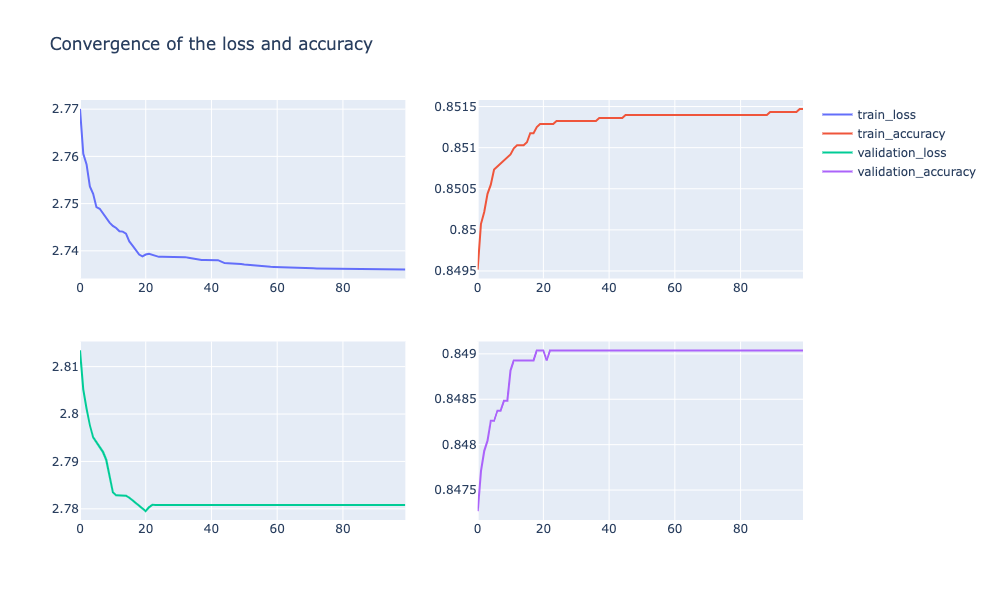

Execution Time:  23.999775886535645


In [89]:
if __name__ == "__main__":
    LR = LogisticRegression()
    start = time.time()
    LR.train_loopRetroApprox(100)
    end = time.time()
    print('Execution Time: ', end - start)

We can see that, at the start, this adapted "Logistic Regression" with the "Retrospective Approximation" quickly converges towards the optimum before moving rather constantly. However, the Retrospective Approximation algorithm has a larger error than the SAG on the whole graph. 

On a few occasions, as the sample size increases, the algorithm takes a considerable amount of time to arrive at a solution (which satisfies the desired error threshold) depending on the new data in the sample with each iteration. Of course, the larger the sample, the more time it takes for an iteration to increase to achieve a desired level of performance. The iteration cost is therefore dependent on the new data in the sample to analyze. Because new samples less representative of the dataset have sometimes increased the optimal function that we wish to minimize, for which an "Early-Stopping" technique would be adequate if it is not possible to perform the function. 'algorithm for a long period of time in order to achieve the optimum.